In [ ]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

path = untar_data(URLs.CIFAR)

In [ ]:
xs = []
ys = []
best_s = []
best_acc = 0
best_learn = None

for s in [64, 224]:
    dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                       get_items=get_image_files,
                       get_y=parent_label,
                       item_tfms=Resize(s))

    dls = dblock.dataloaders(os.path.join(path.__str__(), "train"), bs=64)

    learn = vision_learner(dls, models.resnet18, metrics=accuracy).to_fp16()
    learn.fine_tune(10, freeze_epochs=3)
    learn.save(f"cifar10_{s}")


    # run on test set
    test_files = get_image_files(path / "test")
    label = TensorCategory([dls.vocab.o2i[parent_label(f)] for f in test_files])

    pred = learn.get_preds(dl=dls.test_dl(test_files))
    acc = accuracy(pred[0], label).item()
    print(f"{s}x{s}, test accuracy={acc}")

    if acc > best_acc:
        best_s = s
        best_acc = acc
        best_learn = learn

    xs.append(s)
    ys.append(acc)

In [ ]:
#Training time Augmentation
preds,targs = learn.tta()
accuracy(preds, targs).item()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


64x64, test accuracy=0.8934999704360962


224x224, test accuracy=0.9459999799728394


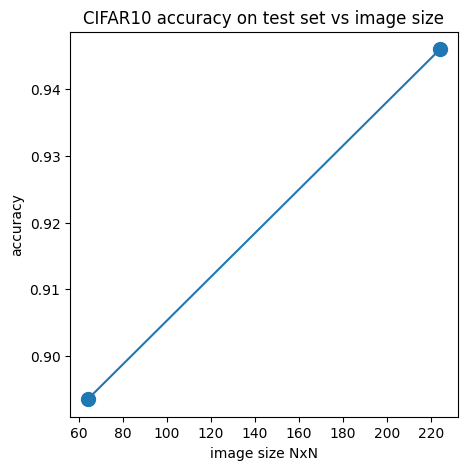

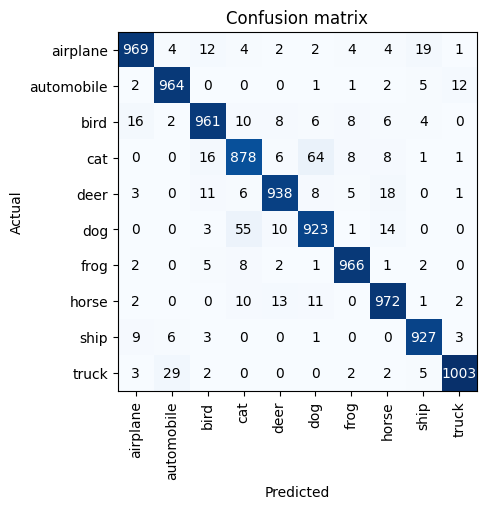

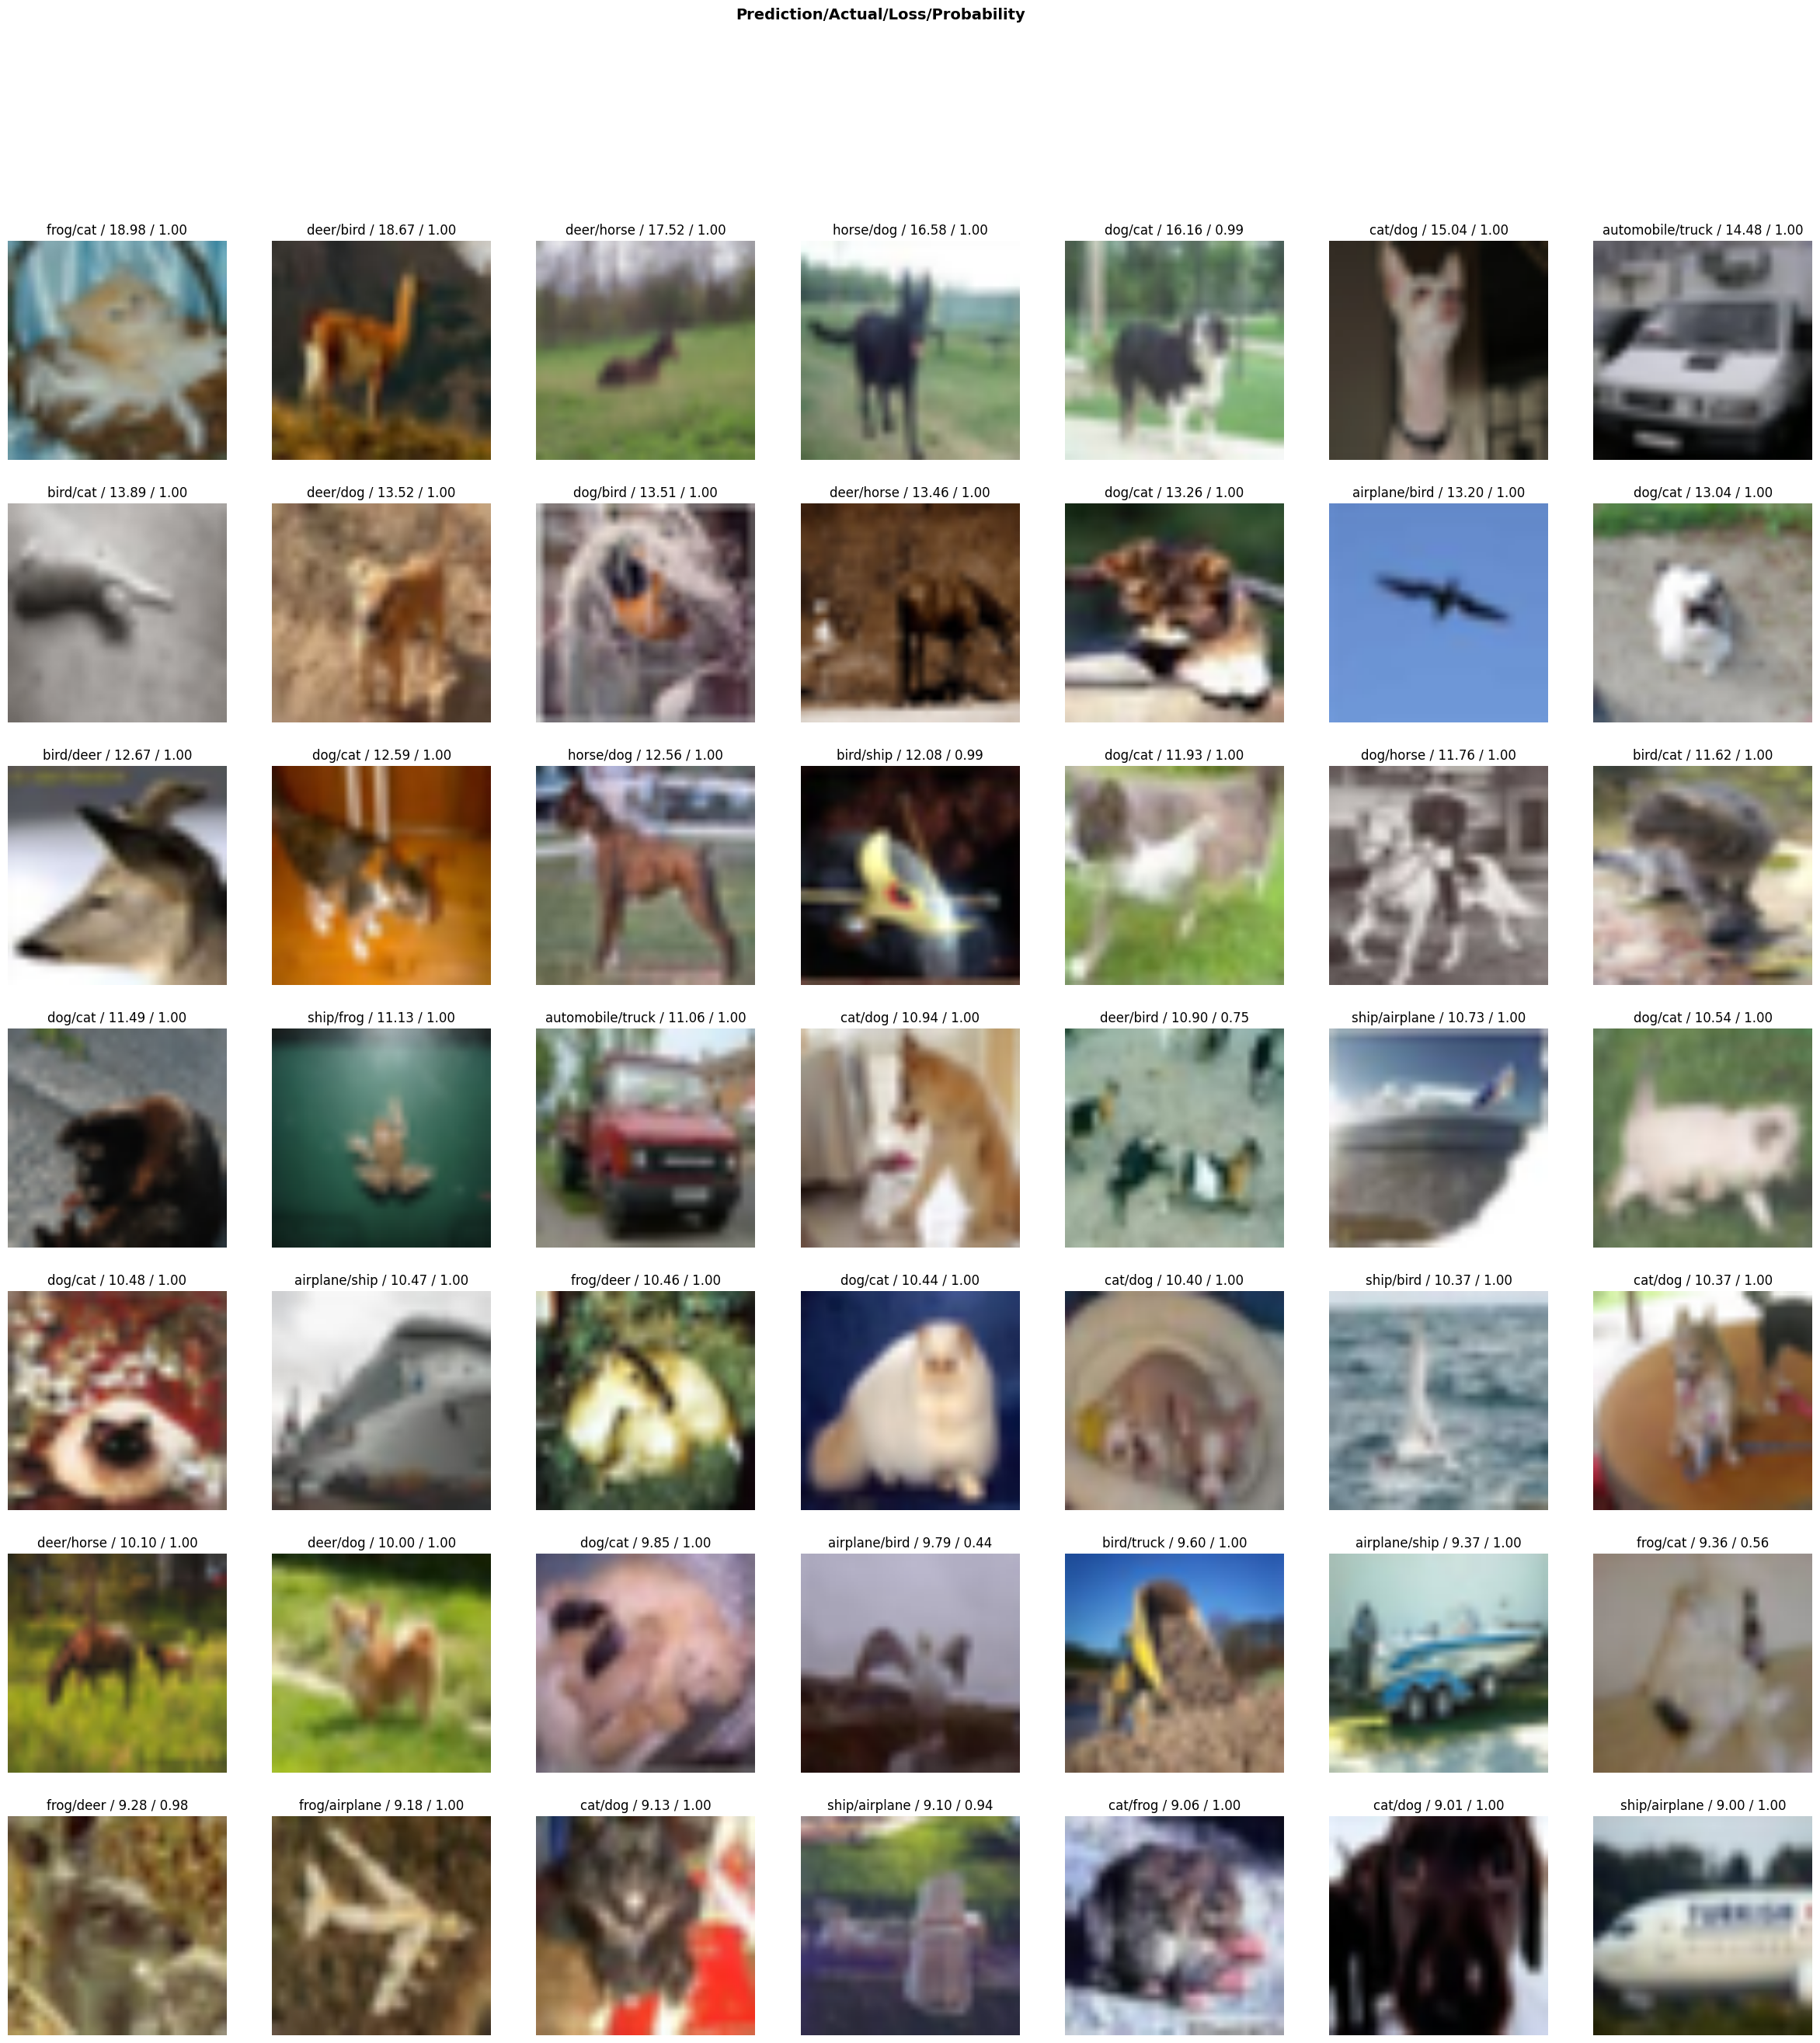

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(xs, ys, 'o-', markersize=10)
plt.xlabel("image size NxN")
plt.ylabel("accuracy")
plt.title("CIFAR10 accuracy on test set vs image size");

interp = ClassificationInterpretation.from_learner(best_learn)
interp.plot_confusion_matrix(figsize=(5,5))
interp.plot_top_losses(49, figsize=(30,30))